In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from data_loading import get_amazon_data
from evaluation import evaluate_policy, create_offline_dataset
from policies.bcmabrp import BCMABRP
from policies.cbrap import CBRAP
from policies.linucb import LinUCB
from policies.linear_ts import LinearTS
from policies.random import RandomPolicy
from policies.egreedy import EGreedy
from reduct_matrix import get_reduct_matrix

from sklearn.model_selection import train_test_split

In [4]:
PROJECT_DIR = '.'

In [5]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [6]:
dataset = get_amazon_data()

In [7]:
red_dim = 60
reduct_matrix = get_reduct_matrix("amazon", red_dim, load_old_reduct_matrix=False)

In [8]:
times = 30000

In [9]:
def plot_ctrs(reward_dict):
    fig, ax = plt.subplots(1,1, figsize=(15, 7));
    
    N = 300
    
    reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, reward in reward_list:
        times = (range(1, len(reward)+1))
        ctr = [r/t for r,t in zip(reward, times)]
        ax.plot(ctr[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('CTR')
    ax.set_title('CTR on Amazon')

    plt.legend();
    plt.show();

In [10]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15, 7));
    
    N = 300
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on Amazon')

    plt.legend();
    plt.show();

### Define policies

In [11]:
total_start_ts = time.time()

In [12]:
ctx_dim = 100
red_dim = 60

policies = {
    'BCMABRP 0.15': lambda : BCMABRP(
        context_dimension=ctx_dim, red_dim=red_dim, reduct_matrix=reduct_matrix, nu=0.15, seed=seed
    ),
    'CBRAP': lambda : CBRAP(context_dimension=ctx_dim, red_dim=red_dim, reduct_matrix=reduct_matrix, alpha=0.5),
    'EGreedy': lambda : EGreedy(epsilon=0.5),
    'LinearTS': lambda : LinearTS(context_dimension=ctx_dim, nu=0.3, seed=seed),
    'LinUCB': lambda : LinUCB(context_dimension=ctx_dim, alpha=0.8),
    'Random': lambda : RandomPolicy(),
}

### Run evaluation

In [13]:
num_reps = 1

results = {'reward': {}, 'ndcg': {}}
for p_name, policy_gen in policies.items():
    start_ts = time.time()
    rews = np.zeros((num_reps, times))
    ndcgs = np.zeros((num_reps, times))
    for rep in range(num_reps):
        policy = policy_gen()
        reward, ndcg = evaluate_policy(policy, times, dataset)
        rews[rep, :] = reward.flatten()
        ndcgs[rep, :] = ndcg.flatten()
    reward = np.mean(rews, axis=0)
    ndcg = np.mean(ndcgs, axis=0)
    results['reward'][p_name] = reward
    results['ndcg'][p_name] = ndcg
    print(f"Total reward of {p_name} is {reward[-1]}")
    print(f"Total time of {p_name} is {datetime.timedelta(seconds=time.time() - start_ts)}")

First user in exp from 2017-06-23 02:00:00
Last user in exp from 2018-09-22 02:00:00
0
5000
10000
15000
20000
25000
Total reward of BCMABRP 0.15 is 2078.0
Total time of BCMABRP 0.15 is 0:10:54.721454
First user in exp from 2017-06-23 02:00:00
Last user in exp from 2018-09-22 02:00:00
0
5000
10000
15000
20000
25000
Total reward of CBRAP is 2832.0
Total time of CBRAP is 0:10:14.106568
First user in exp from 2017-06-23 02:00:00
Last user in exp from 2018-09-22 02:00:00
0
5000
10000
15000
20000
25000
Total reward of EGreedy is 1444.0
Total time of EGreedy is 0:00:20.886590
First user in exp from 2017-06-23 02:00:00
Last user in exp from 2018-09-22 02:00:00
0
5000
10000
15000
20000
25000
Total reward of LinearTS is 2450.0
Total time of LinearTS is 0:23:39.903329
First user in exp from 2017-06-23 02:00:00
Last user in exp from 2018-09-22 02:00:00
0
5000
10000
15000
20000
25000
Total reward of LinUCB is 2346.0
Total time of LinUCB is 0:10:48.158121
First user in exp from 2017-06-23 02:00:00
L

### Plot results

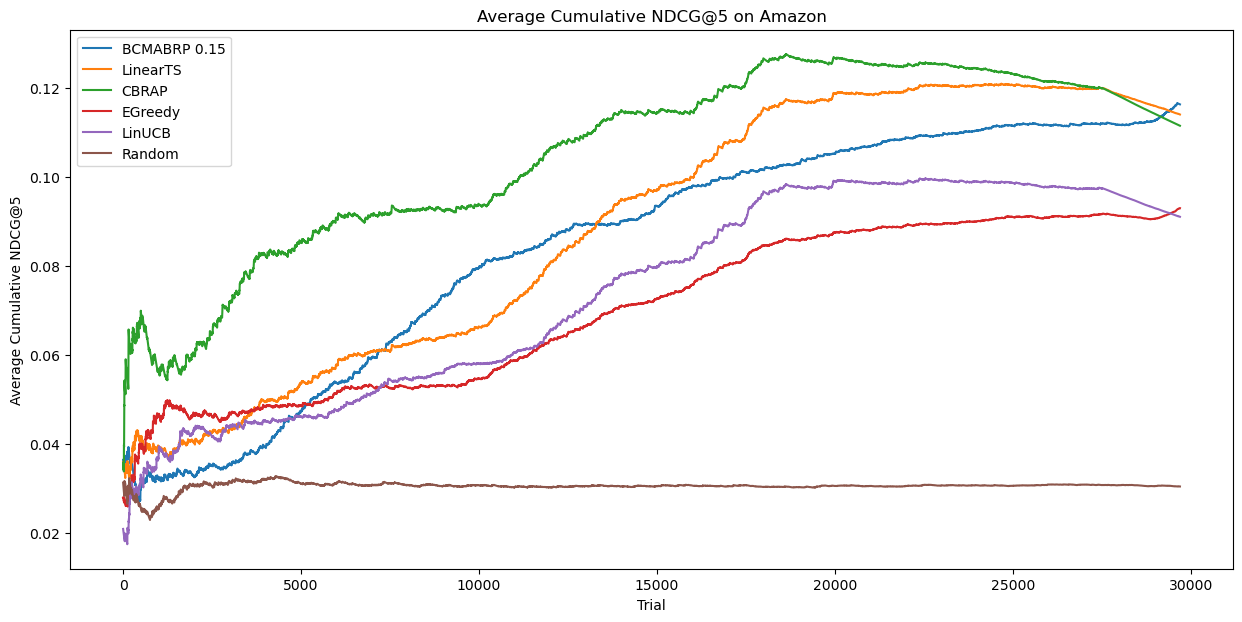

In [14]:
plot_ndcg(results['ndcg'])

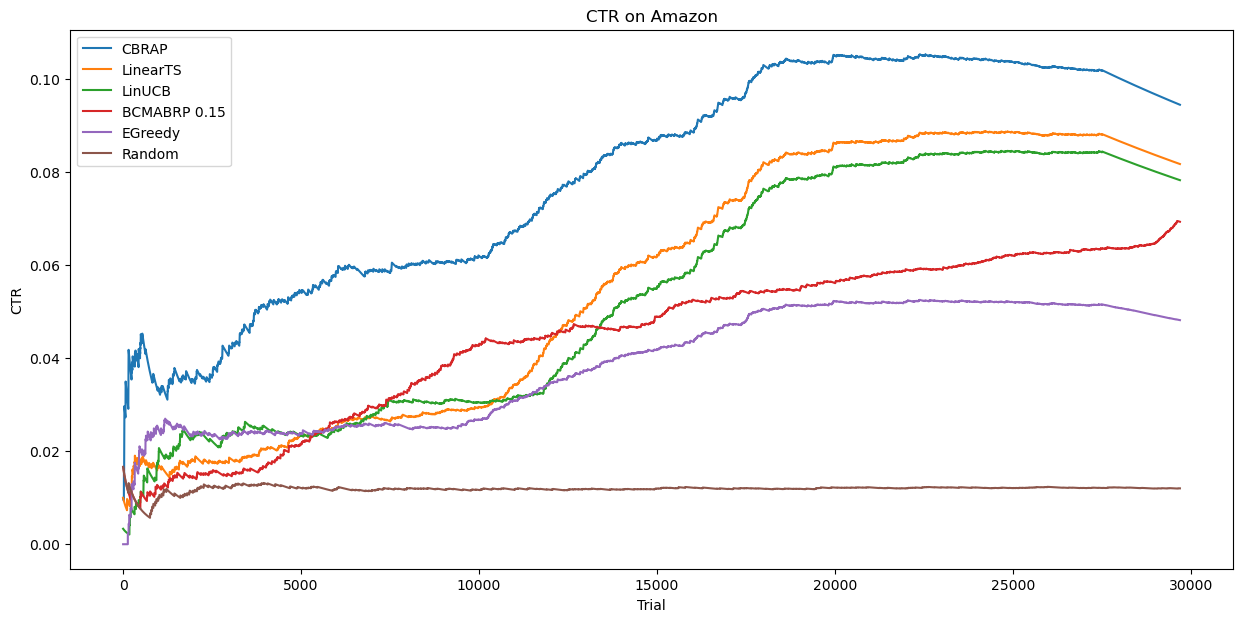

In [15]:
plot_ctrs(results['reward'])

In [16]:
print(f"Total time is {datetime.timedelta(seconds=time.time() - total_start_ts)}")

Total time is 0:56:23.561671
